<a href="https://colab.research.google.com/github/ujjawalsingh10/Pytorch-Deep-Learning/blob/main/02_Pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Make Classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples=n_samples,
                   noise = 0.03,
                   random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [5]:
y[:5]

array([1, 1, 1, 1, 0])

In [6]:
## Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({'X1' : X[:,0],
                        'X2' : X[:,1],
                        'label' : y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


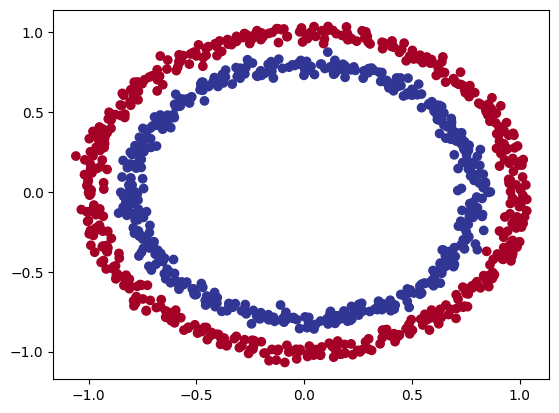

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Checking input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X[0]

array([0.75424625, 0.23148074])

In [10]:
## View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Sample input features: {X_sample}')
print(f'Sample target label: {y_sample}')

Sample input features: [0.75424625 0.23148074]
Sample target label: 1


### 1.2 Turn data into tensors and create train and test splits

In [11]:
# Turn data into tensors
import torch
torch.__version__

'2.5.1+cu121'

In [12]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [13]:
## Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
## SPlit data into training and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building a model

In [16]:
import torch
from torch import nn

## Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [17]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, x:torch.Tensor) ->  torch.Tensor:
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
## Replicating the model aboce using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
## Make predictions
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3686, -0.6751],
                      [-0.6467,  0.4805],
                      [-0.0292, -0.5726],
                      [ 0.2918,  0.4393],
                      [-0.1638,  0.6598]])),
             ('0.bias', tensor([ 0.6522, -0.3603, -0.5740, -0.5362, -0.6587])),
             ('1.weight',
              tensor([[-0.1334, -0.0722,  0.2851,  0.0387,  0.1745]])),
             ('1.bias', tensor([-0.2731]))])

In [20]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds[:10], y_test[:10]

(tensor([[-0.6063],
         [-0.6105],
         [-0.6212],
         [-0.6019],
         [-0.6627],
         [-0.6649],
         [-0.6441],
         [-0.6569],
         [-0.6195],
         [-0.6113]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 2.1 Setup loss function and optimizer

In [21]:
# loss_fn = nn.BCELoss() ## requires inputs to have gone through the sigmoid function prior to input to bceloss
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# ) ## gives bcewithlogitloss
loss_fn = nn.BCEWithLogitsLoss() ## Sigmoid act. function built in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [22]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_true)) * 100
  return acc

## 3. Train Model


1.   Forward Pass
2.   Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backprop)
5. Optimizer Step (grad desc)



### 3.1 going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

we can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification)

In [23]:
## View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.6063],
        [-0.6105],
        [-0.6212],
        [-0.6019],
        [-0.6627]])

In [24]:
# Use the sigmoid function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3529],
        [0.3519],
        [0.3495],
        [0.3539],
        [0.3401]])

In [25]:
# ## Find the predicted labels
# y_preds = torch.round(y_pred_probs)

# ## checking for equality
# torch.eq(y_preds.squeeze(), y_pred)

## 3.2 Building a training and testing loop

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

## Putting the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## Building training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  ## 1. forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) ## Turn logits -> pred probs using sigmoid -> pred labels using round

  ## 2. Calculate loss and accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) ### nn.bceloss expects prediction probabilities as input
  loss = loss_fn(y_logits, y_train) ## we using logits here cuz... bcewithlogitloss uses sigmoid itself ,,, this expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred = y_pred)

  ## 3. optimizer zero grad
  optimizer.zero_grad()

  ## 4 Loss backward
  loss.backward()

  ## 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calc. test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  ## Print out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.74253, Acc: 50.00% | Test Loss: 0.73615, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70701, Acc: 50.00% | Test Loss: 0.70412, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69832, Acc: 50.00% | Test Loss: 0.69579, Test Acc: 50.00%
Epoch: 30 | Loss: 0.69585, Acc: 40.62% | Test Loss: 0.69341, Test Acc: 42.50%
Epoch: 40 | Loss: 0.69490, Acc: 46.38% | Test Loss: 0.69267, Test Acc: 48.50%
Epoch: 50 | Loss: 0.69439, Acc: 46.88% | Test Loss: 0.69246, Test Acc: 48.00%
Epoch: 60 | Loss: 0.69406, Acc: 47.62% | Test Loss: 0.69244, Test Acc: 50.00%
Epoch: 70 | Loss: 0.69381, Acc: 48.00% | Test Loss: 0.69251, Test Acc: 50.00%
Epoch: 80 | Loss: 0.69363, Acc: 48.12% | Test Loss: 0.69262, Test Acc: 49.50%
Epoch: 90 | Loss: 0.69348, Acc: 47.50% | Test Loss: 0.69274, Test Acc: 48.50%


## Make predictions and evaluate the model



In [37]:
import requests
from pathlib import Path

## Download helper function
if Path('helper_functions.py').is_file():
  print('Helper function.py already exists, skipping download')
else:
  print('Downloading helper_functions.py')
  response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py', 'w') as f:
    f.write(response.content.decode('utf-8'))

# from helper_functions import plot_predictions, plot_decision_boundary

Helper function.py already exists, skipping download


In [41]:
# from helper_functions import plot_predictions, plot_decision_boundary

def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

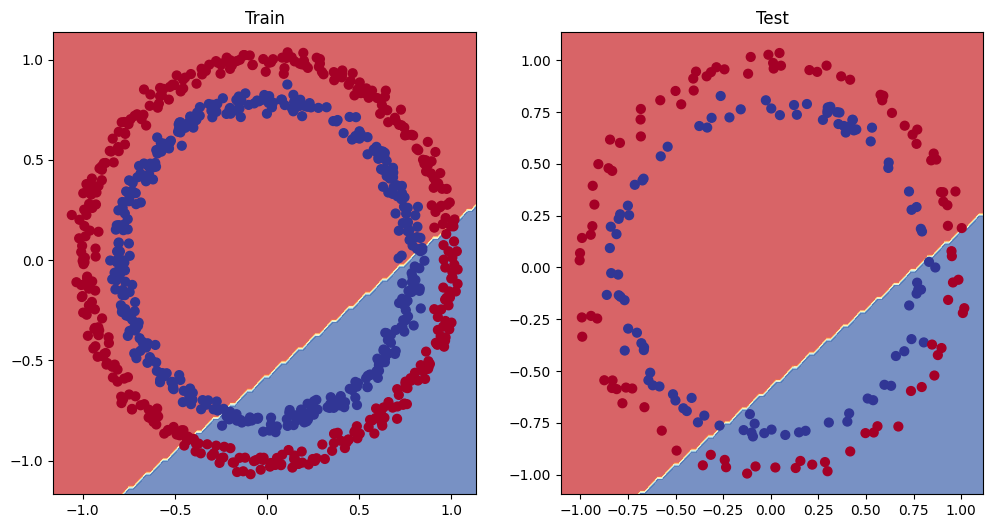

In [43]:
import numpy as np
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model perspective)

In [44]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [45]:
## Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

## Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred=y_pred,
                    y_true=y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Loss calculation
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  ## Printing results
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 10 | Loss: 0.69369, Acc: 50.25% | Test Loss: 0.69270, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69351, Acc: 50.12% | Test Loss: 0.69283, Test Acc: 49.50%
Epoch: 30 | Loss: 0.69339, Acc: 50.50% | Test Loss: 0.69297, Test Acc: 48.00%
Epoch: 40 | Loss: 0.69329, Acc: 50.38% | Test Loss: 0.69310, Test Acc: 49.00%
Epoch: 50 | Loss: 0.69322, Acc: 49.88% | Test Loss: 0.69324, Test Acc: 50.00%
Epoch: 60 | Loss: 0.69317, Acc: 49.38% | Test Loss: 0.69336, Test Acc: 51.50%
Epoch: 70 | Loss: 0.69312, Acc: 49.38% | Test Loss: 0.69348, Test Acc: 50.50%
Epoch: 80 | Loss: 0.69309, Acc: 50.12% | Test Loss: 0.69359, Test Acc: 50.00%
Epoch: 90 | Loss: 0.69307, Acc: 50.50% | Test Loss: 0.69370, Test Acc: 48.50%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 110 | Loss: 0.69303, Acc: 50.88% | Test Loss: 0.69388, Test Acc: 46.50%
Epoch: 120 | Loss: 0.69302, Acc: 50.75% | Test Loss: 0.69396, T

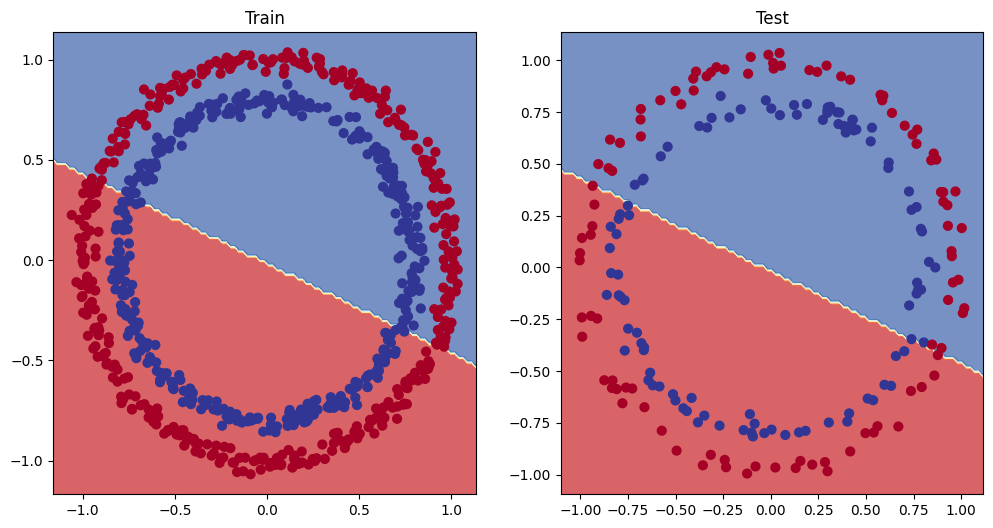

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

In [48]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

## Create Data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

## 6. Non linearity

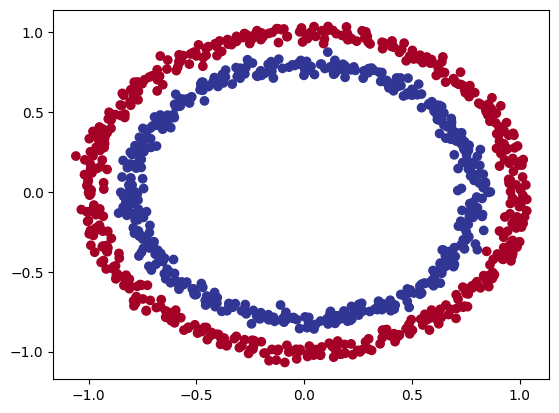

In [49]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [50]:
## Convert data to tensors
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## Building a model with Non linearity

In [51]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [52]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [53]:
## Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr = 0.1)

### Training a model with non linearity

In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  ## 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  ## 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  ## 3. Optimizer zero grad
  optimizer.zero_grad()

  ## 4. Loss backward
  loss.backward()

  ## 5. Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  ## printing results
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.69319, Test Acc: 50.00% 
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test Loss: 0.69102, Test Acc: 52.50% 
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test Loss: 0.68940, Test Acc: 55.00% 
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test Loss: 0.68723, Test Acc: 56.00% 
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test Loss: 0.68411, Test Acc: 56.50% 
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test Loss: 0.67941, Test Acc: 56.50% 
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test Loss: 0.67285, Test Acc: 56.00% 
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test Loss: 0.66322, Test Acc: 59.00% 
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test Loss: 0.64757, Test Acc: 67.50% 
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test Loss: 0.62145, Test Acc: 79.00% 


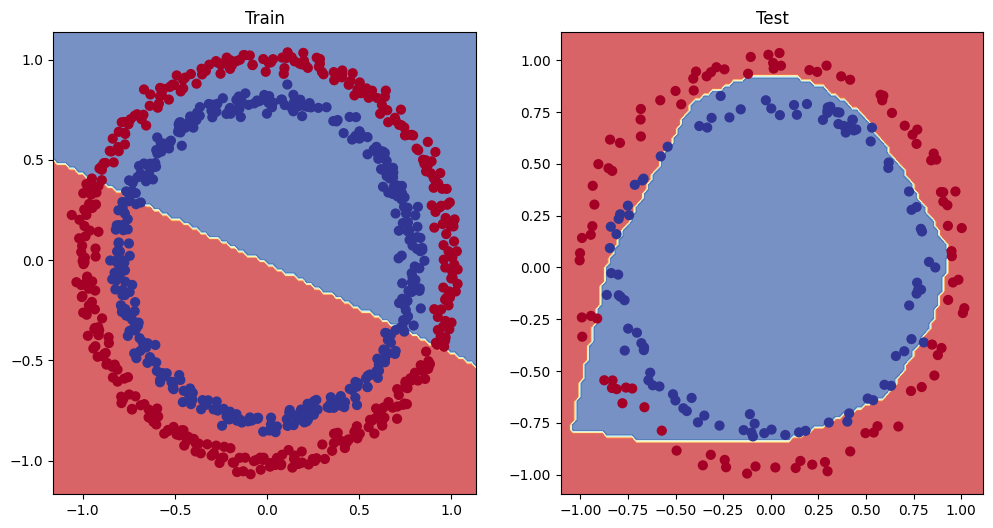

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non linear activation functions

In [60]:
## Creating a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

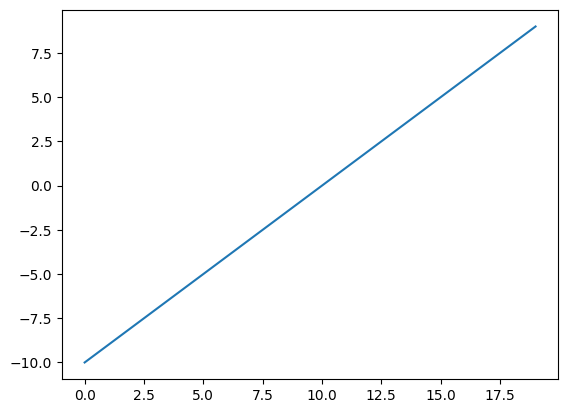

In [61]:
## Visualize the tensor
plt.plot(A)

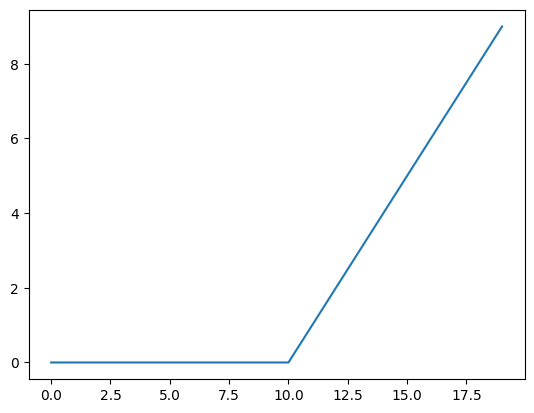

In [62]:
plt.plot(torch.relu(A));

In [75]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0),x) ## inputs must be tensor

In [78]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [79]:
def sig(x):
  return 1 / (1 + torch.exp(-x))

In [80]:
sig(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

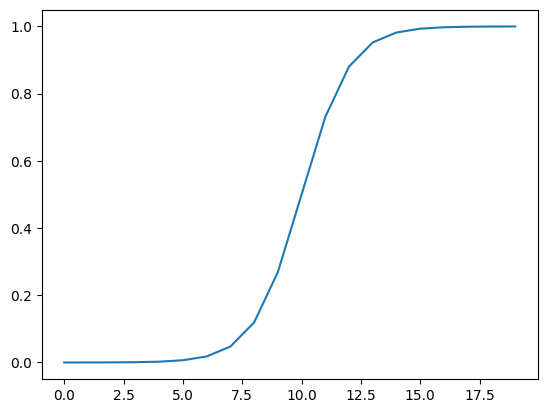

In [81]:
plt.plot(sig(A))

## 8. Putting it all together with multiclass classification problem

### 8.1 Creating a toy multi class dataset

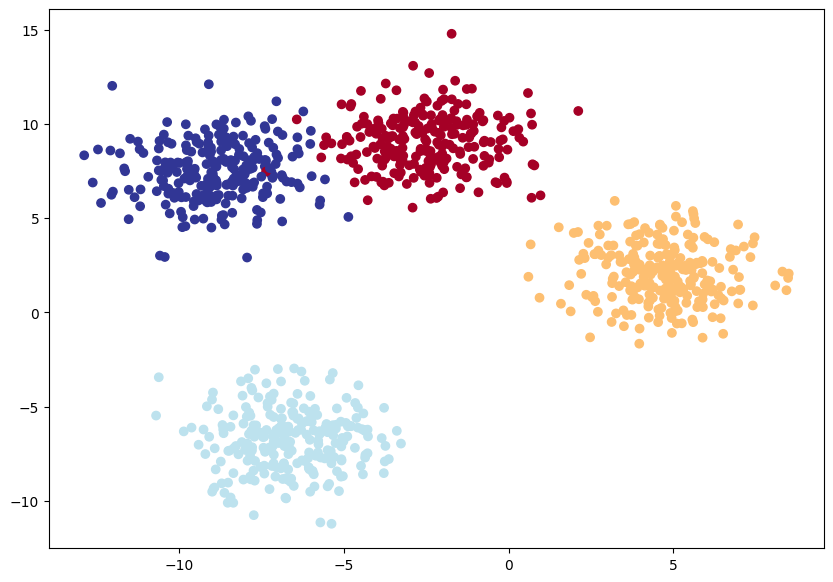

In [96]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## setting the parameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

## create multi class data
X, y = make_blobs(n_samples = 1000,
                  n_features = NUM_FEATURES,
                  centers = NUM_CLASSES,
                  cluster_std = 1.5,
                  random_state = RANDOM_SEED)

## Turn the data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

## Splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = RANDOM_SEED)

## Visualize the data
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [86]:
X[:5], y[:5]

(array([[-8.55503989,  7.06461794],
        [-6.13753182, -6.58081701],
        [-6.32130028, -6.8041042 ],
        [ 4.18051794,  1.12332531],
        [ 4.38028748,  0.47002673]]),
 array([3, 2, 2, 1, 1]))

### 8.2 Building a multi class classification

In [97]:
## Create agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [103]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    """ Initializes multi class classification model
    Args:
      input features (int): number of input features to the model
      output_features (int): number of output features of the model
      hidden_units (int): number of hidden units between layers, default 8
    """
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

## creating instance of BlobModel
blob_model = BlobModel(input_features = 2,
                       output_features = 4,
                       hidden_units = 8).to(device)
blob_model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [106]:
len(y.unique())

4

### 8.3 Create a loss function and an optimizer for a multi class classification model

In [107]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = blob_model.parameters(),
                            lr = 0.1)

### 8.4 Getting prediction probabilities for multi class pytorch model

In [112]:
blob_model.eval()
with torch.inference_mode():
  y_logits = blob_model(X_test)
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [114]:
## convert our models logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:5], y_logits[:5]

(tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]]),
 tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]))

In [115]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [116]:
torch.max(y_pred_probs[0])

tensor(0.3244)

In [117]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [118]:
## Convert our models prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

### 8.5 Creating a training loop for a multi class model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

 for epoch in range(epochs):
  ### Training
  blob_model.train()

  y_logits = blob_model(X_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


